In [113]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import h5py
import arviz as az
import rpy2.robjects as robjects
import matplotlib.cm as cm

cols = [col for i, col in enumerate(cm.tab20.colors) if i % 2 == 0]
cols.append(cm.Dark2(6))
cols = cols + [col for i, col in enumerate(cm.tab20.colors) if i % 2 != 0]
cols

[(0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [3]:
taxa = ['B_caccae',
        'B_cellulosilyticus_WH2',
        'B_ovatus',
        'B_thetaiotaomicron',
        'B_uniformis',
        'B_vulgatus',
        'C_aerofaciens',
        'C_scindens',
        'C_spiroforme',
        'D_longicatena',
        'P_distasonis',
        'R_obeum']

pretty_names_dir = {'B_caccae': '$B. caccae$',
                'B_cellulosilyticus_WH2': '$B. cellulosilyticus$',
                'B_ovatus': '$B. ovatus$',
                'B_thetaiotaomicron': '$B. thetaiotaomicron$',
                'B_uniformis': '$B. uniformis$',
                'B_vulgatus': '$B. vulgatus$',
                'C_aerofaciens': '$C. aerofaciens$',
                'C_scindens': '$C. scindens$',
                'C_spiroforme': '$C. spiroforme$',
                'D_longicatena': '$D. longicatena$',
                'P_distasonis': '$P. distasonis$',
                'R_obeum': '$R. obeum$'}

In [4]:
path = Path(f'mcnulty-results/both/posteriors')
burn_in = 1000
seeds = [0, 3, 4, 23, 127]

In [ ]:
def load_traces(key, dataset, seeds=seeds, burn_in=burn_in):
    traces = []
    for seed in seeds:
        filename = Path(f'{input_folder}/mcnulty_{dataset}_seed{seed}/traces.hdf5')
        with h5py.File(path, 'r') as f:
            trace = f[key][()][burn_in:]
            traces.append(trace)
    traces = np.array(traces)
    traces = np.nan_to_num(traces)
    return traces

def save_trace_as_rds(key, dataset, seeds=seeds, burn_in=burn_in):
    traces = load_traces(key=key, dataset=dataset, seeds=seeds, burn_in=burn_in)
    traces_flatten = traces.flatten('F')
    traces2r = robjects.r['array'](robjects.FloatVector(traces_flatten), dim=robjects.IntVector(traces.shape))
    robjects.r['saveRDS'](traces2r, file = f'{input_folder}/mcnulty_{dataset}_seed{seed}/posteriors/{key.replace(' ', '_')}.rds')

def plot_forest(key, dataset, seeds=seeds, burn_in=burn_in):
    traces = load_traces(key=key, dataset=dataset, seeds=seeds, burn_in=burn_in)
    plot_path = Path(f'{output_path}/{dataset}/diagnostics')
    plot_path.mkdir(parents=True, exist_ok=True)
    if key in ['Growth parameter', 'Self interaction parameter', 'Perturbation object', 'Process Variance parameter']:
        traces_az = az.convert_to_inference_data(traces)
        axes = az.plot_forest(traces_az, ess=True, r_hat=True, figsize=(14, 8), combined=True, colors='black')
        axes[0].set_title(f'{growth_key} 94% HDI')
        axes[1].set_title(f'{growth_key} ess')
        axes[2].set_title(f'{growth_key} ' '$\hat{r}$')
        plt.savefig(f'{plot_path}/{key.replace(' ', '_')}.png', dpi=300)
        plt.close()
    elif key == 'Interactions object':
        interaction = []
        for i in range(len(taxa)):
            species1 = taxa[i]
            species2 = taxa.copy()
            species2.pop(i)
            inter = np.ma.array(traces[:,:,i,:], mask=False)
            inter.mask[:,:,i] = True
            inter = inter[~inter.mask].reshape(inter.shape[0], inter.shape[1], -1)
            interactions_az = az.convert_to_inference_data(inter)
            axes = az.plot_forest(interactions_az, ess=True, r_hat=True, figsize=(14, 8), combined=True, colors='black')
            axes[0].set_title(f'{key} 94% HDI')
            axes[1].set_title(f'{key} ess')
            axes[2].set_title(f'{key} ' '$\hat{r}$')
            plt.savefig(f'{plot_path}/{key.replace(' ', '_')}_for_{species1}.png', dpi=300)
            plt.close()

def plot_rank(key, dataset, seeds=seeds, burn_in=burn_in):
    traces = load_traces(key=key, dataset=dataset, seeds=seeds, burn_in=burn_in)
    plot_path = Path(f'{output_path}/{dataset}/diagnostics')
    plot_path.mkdir(parents=True, exist_ok=True)
    if key in ['Growth parameter', 'Self interaction parameter', 'Perturbation object', 'Process Variance parameter']:
        traces_az = az.convert_to_inference_data(traces)
        az.plot_rank(traces_az, colors=cols)
        plt.savefig(f'{plot_path}/{key.replace(' ', '_')}.png', dpi=300)
        plt.close()
    elif key == 'Interactions object':
        interaction = []
        for i in range(len(taxa)):
            species1 = taxa[i]
            species2 = taxa.copy()
            species2.pop(i)
            inter = np.ma.array(traces[:,:,i,:], mask=False)
            inter.mask[:,:,i] = True
            inter = inter[~inter.mask].reshape(inter.shape[0], inter.shape[1], -1)
            interactions_az = az.convert_to_inference_data(inter)
            az.plot_rank(interactions_az, colors=cols)
            plt.savefig(f'{plot_path}/{key.replace(' ', '_')}_for_{species1}.png', dpi=300)
            plt.close()

def plot_rank_vlines(key, dataset, seeds=seeds, burn_in=burn_in):
    traces = load_traces(key=key, dataset=dataset, seeds=seeds, burn_in=burn_in)
    plot_path = Path(f'{output_path}/{dataset}/diagnostics')
    plot_path.mkdir(parents=True, exist_ok=True)
    if key in ['Growth parameter', 'Self interaction parameter', 'Perturbation object', 'Process Variance parameter']:
        traces_az = az.convert_to_inference_data(traces)
        az.plot_rank(traces_az, kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3}, colors=cols)
        plt.savefig(f'{plot_path}/{key.replace(' ', '_')}.png', dpi=300)
        plt.close()
    elif key == 'Interactions object':
        interaction = []
        for i in range(len(taxa)):
            species1 = taxa[i]
            species2 = taxa.copy()
            species2.pop(i)
            inter = np.ma.array(traces[:,:,i,:], mask=False)
            inter.mask[:,:,i] = True
            inter = inter[~inter.mask].reshape(inter.shape[0], inter.shape[1], -1)
            interactions_az = az.convert_to_inference_data(inter)
            az.plot_rank(interactions_az, kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3}, colors=cols)
            plt.savefig(f'{plot_path}/{key.replace(' ', '_')}_for_{species1}.png', dpi=300)
            plt.close()

def get_bayesian_summary(key, dataset, seeds=seeds, burn_in=burn_in):
    traces = load_traces(key=key, dataset=dataset, seeds=seeds, burn_in=burn_in)
    out_path = Path(f'{output_path}/{dataset}/diagnostics')
    out_path.mkdir(parents=True, exist_ok=True)
    if key in ['Growth parameter', 'Self interaction parameter', 'Perturbation object', 'Process Variance parameter']:
        traces_az = az.convert_to_inference_data(traces)
        summary = az.summary(traces_az)
        summary.index = taxa
        summary.to_csv(f'{out_path}/{key.replace(' ', '_')}_diag_summary.tsv', sep='\t', index=True)
    elif key == 'Interactions object':
        diagn = []
        for i in range(len(taxa)):
            species2 = taxa.copy()
            species2.pop(i)
            inter = np.ma.array(traces[:,:,i,:], mask=False)
            inter.mask[:,:,i] = True
            inter = inter[~inter.mask].reshape(inter.shape[0], inter.shape[1], -1)
            interactions_az = az.convert_to_inference_data(inter)
            interactions_summary = az.summary(interactions_az)
            interactions_summary.index = species2
            interactions_summary.index.name = 'species2'
            interactions_summary['species1'] = taxa[i]
            interactions_summary.reset_index(inplace=True)
            interactions_summary.set_index(['species1', 'species2'], inplace=True)
            diagn.append(interactions_summary)
        diagn = pd.concat(diagn)
        diagn.to_csv(f'{out_path}/{key.replace(' ', '_')}_diag_summary.tsv', sep='\t', index=True)

In [6]:
cluster_int_ind = []
cluster_int_prob = []
growth = []
self_interaction = []
interactions = []
perturbation = []
process_variance = []

for seed in seeds:
    filename = path / f'traces_lf0_s{seed}.hdf5'
    with h5py.File(filename, "r") as f:
        # Print all root level object names (aka keys) 
        # these can be group or dataset names 
        print("Keys: %s" % f.keys())
        # get first object name/key; may or may NOT be a group
        # cluster_int_ind_key = list(f.keys())[0]
        # cluster_int_prob_key = list(f.keys())[1]
        growth_key = list(f.keys())[2]
        self_interaction_key = list(f.keys())[17]
        interactions_key = list(f.keys())[4]
        perturbation_key = list(f.keys())[3]
        process_variance_key = list(f.keys())[16]

        # If a_group_key is a group name, 
        # this gets the object names in the group and returns as a list
        # Without burn in steps
        # print(cluster_int_ind_key)
        # cluster_int_ind.append(f[cluster_int_ind_key][()][1000:])
        # print(cluster_int_prob_key)
        # cluster_int_prob.append(f[cluster_int_prob_key][()][1000:])
        print(growth_key)
        growth.append(f[growth_key][()][1000:])
        print(self_interaction_key)
        self_interaction.append(f[self_interaction_key][()][1000:])
        print(interactions_key)
        interactions.append(f[interactions_key][()][1000:])
        print('Perturbation object' if perturbation_key in ['HF', 'LF'] else perturbation_key)
        perturbation.append(f['HF/HS'][()][1000:])           # perturbation_key
        print(process_variance_key)
        process_variance.append(f[process_variance_key][()][1000:])

# cluster_int_ind = np.array(cluster_int_ind)
# cluster_int_ind = np.nan_to_num(cluster_int_ind)
# cluster_int_prob = np.array(cluster_int_prob)
# cluster_int_prob = np.nan_to_num(cluster_int_prob)
growth = np.array(growth)
growth = np.nan_to_num(growth)
self_interaction = np.array(self_interaction)
self_interaction = np.nan_to_num(self_interaction)
interactions = np.array(interactions)
interactions = np.nan_to_num(interactions)
perturbation = np.array(perturbation)
perturbation = np.nan_to_num(perturbation)
process_variance = np.array(process_variance)
process_variance = np.nan_to_num(process_variance)

Keys: <KeysViewHDF5 ['Cluster interaction indicator parameter', 'Cluster interaction probability', 'Growth parameter', 'HF', 'Interactions object', 'Latent trajectory parameter_1', 'Latent trajectory parameter_2', 'Latent trajectory parameter_3', 'Latent trajectory parameter_4', 'Latent trajectory parameter_5', 'Latent trajectory parameter_6', 'Latent trajectory parameter_7', 'Mean parameter for the normal prior of the interaction parameter', 'Mean parameter for the normal prior of the perturbation parameter_HF', 'Mean parameter for the truncated normal prior of the growth parameter', 'Mean parameter for the truncated normal prior of the self-interaction parameter', 'Process Variance parameter', 'Self interaction parameter', 'Variance parameter for the normal prior of the interaction parameter', 'Variance parameter for the normal prior of the perturbation parameter_HF']>
Growth parameter
Self interaction parameter
Interactions object
Perturbation object
Process Variance parameter
Keys:

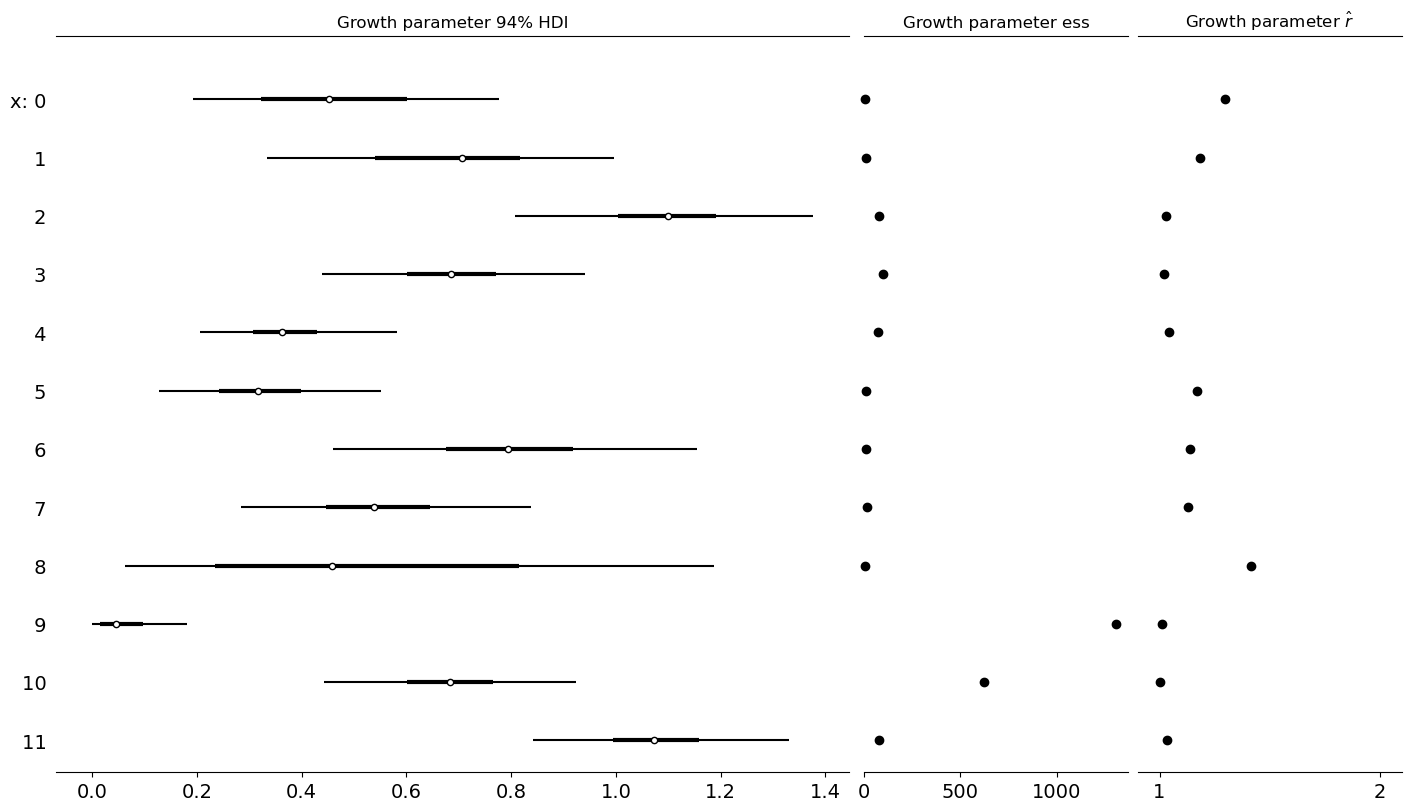

In [122]:
growth_az = az.convert_to_inference_data(growth)
axes = az.plot_forest(growth_az, ess=True, r_hat=True, figsize=(14, 8), combined=True, colors='black')
axes[0].set_title(f'{growth_key} 94% HDI')
axes[1].set_title(f'{growth_key} ess')
axes[2].set_title(f'{growth_key} ' '$\hat{r}$')
# plt.savefig(f'growth.png', dpi=300)

Text(0.5, 1.0, 'Growth parameter $\\hat{r}$')

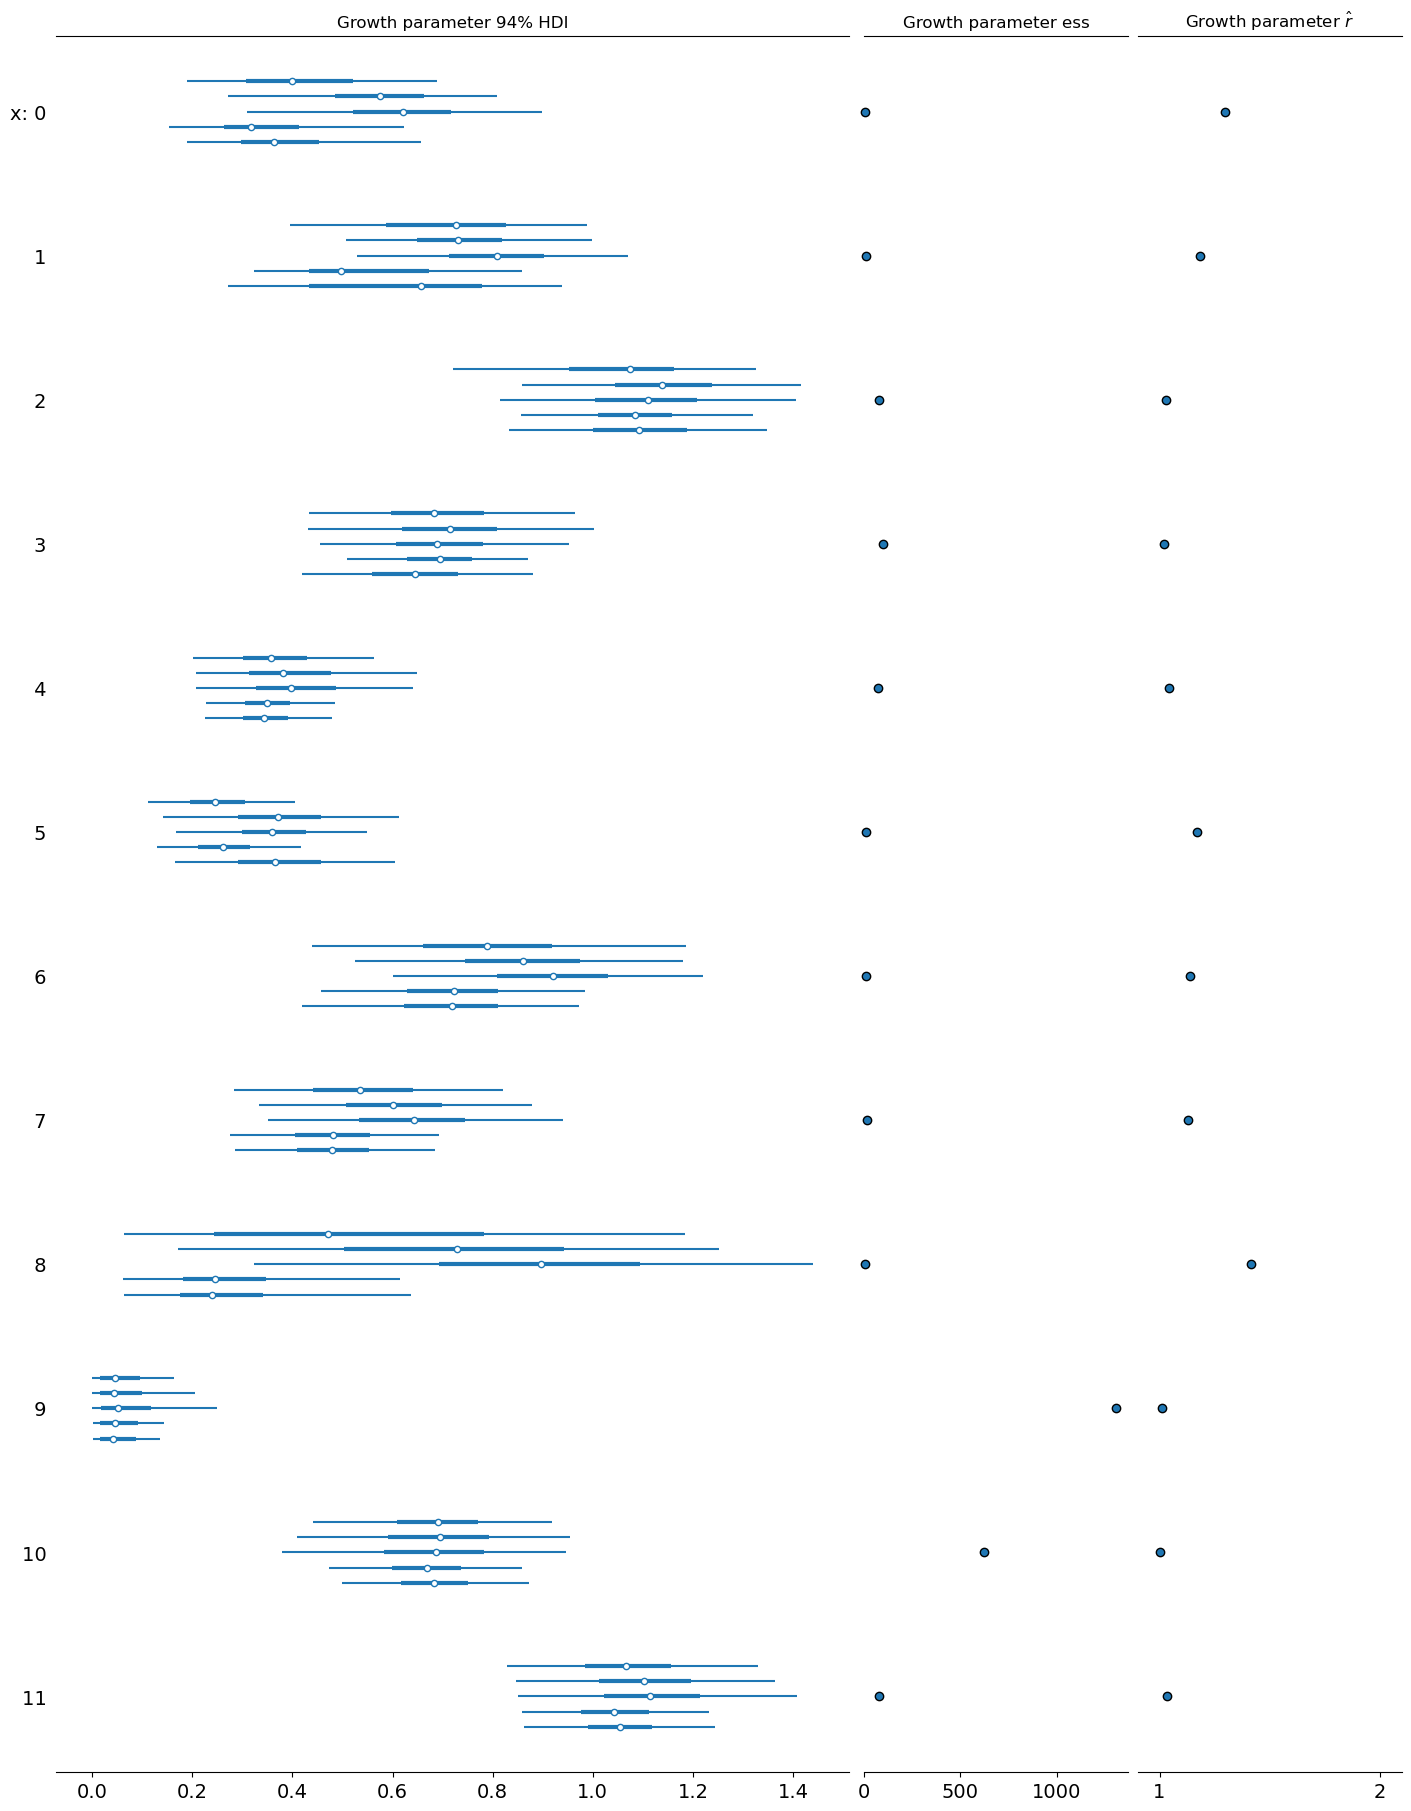

In [118]:
growth_az = az.convert_to_inference_data(growth)
# growth_az = az.convert_to_inference_data(growth[:,:,0])
axes = az.plot_forest(growth_az, ess=True, r_hat=True, figsize=(14, 18))
axes[0].set_title(f'{growth_key} 94% HDI')
axes[1].set_title(f'{growth_key} ess')
axes[2].set_title(f'{growth_key} ' '$\hat{r}$')
# ax.set_ylabel('Growth')
# ax.set_title('Growth')
# ax.set_ylabel('Growth')

Text(0.5, 1.0, 'Growth parameter rank plot')

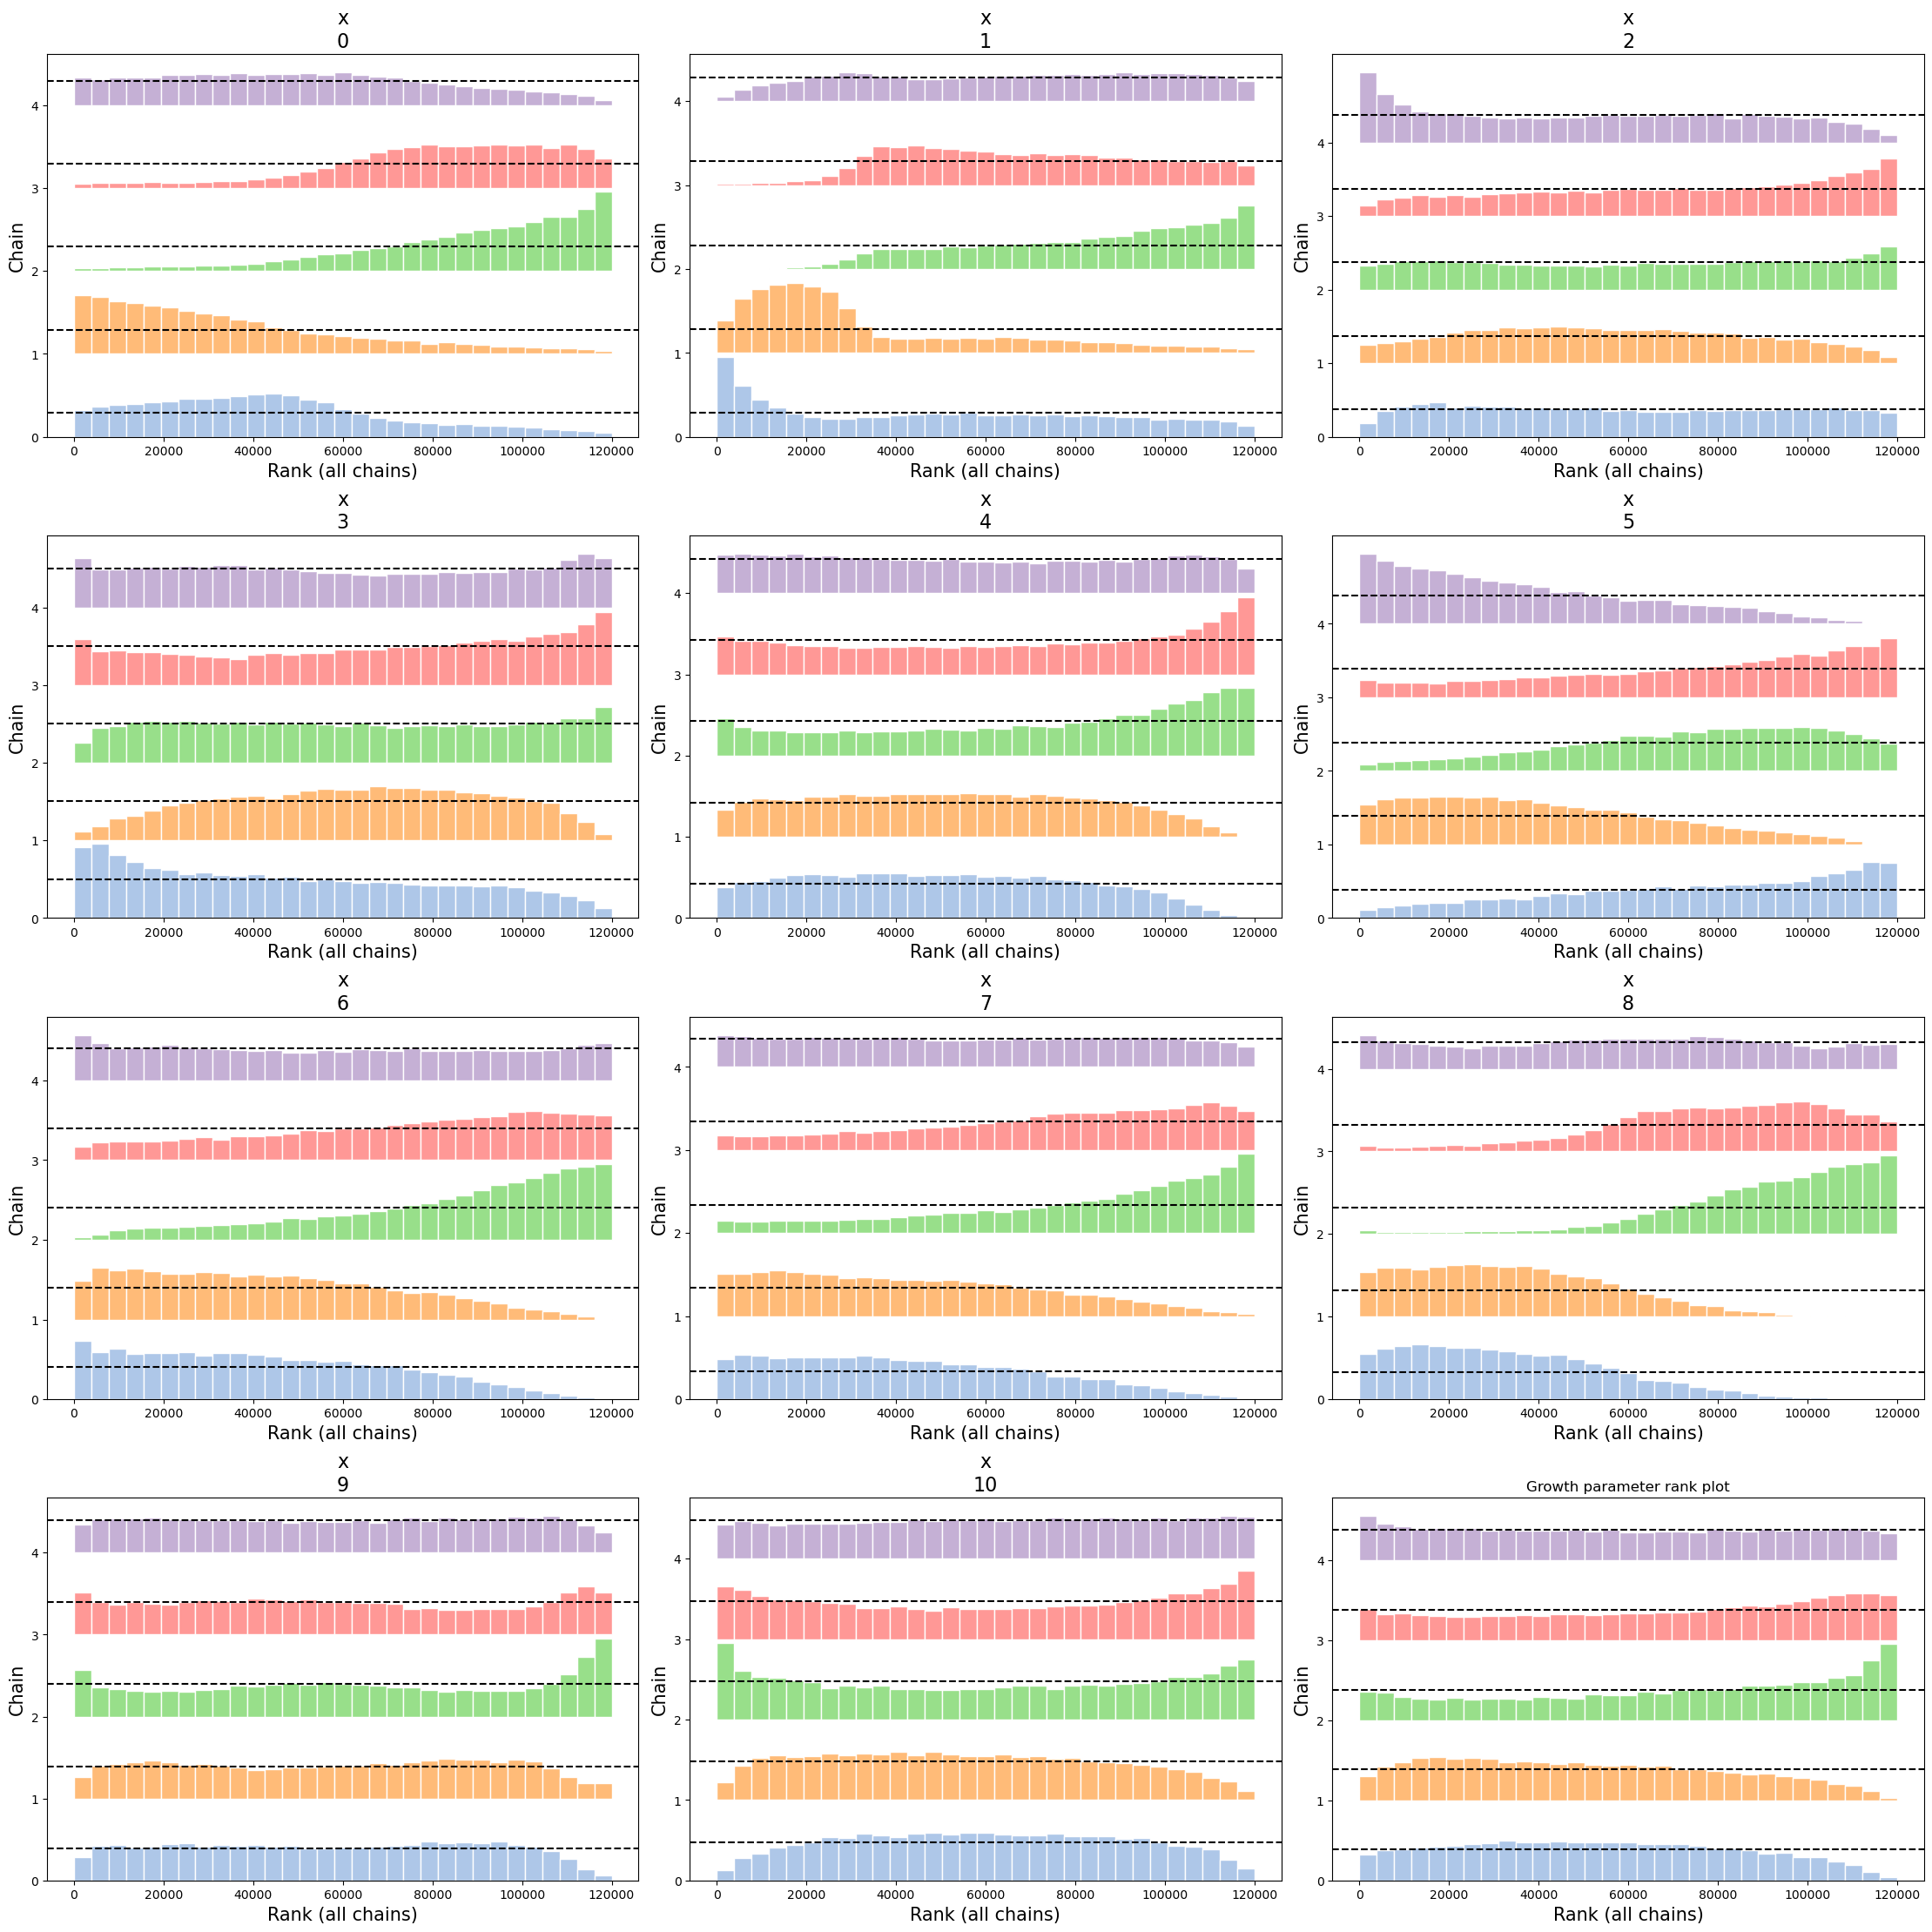

In [116]:
# growth_az = az.convert_to_inference_data(growth)
growth_az = az.convert_to_inference_data(growth)
az.plot_rank(growth_az, colors=cols)
plt.title(f'{growth_key} rank plot')

Text(0.5, 1.0, 'Growth parameter rank plot')

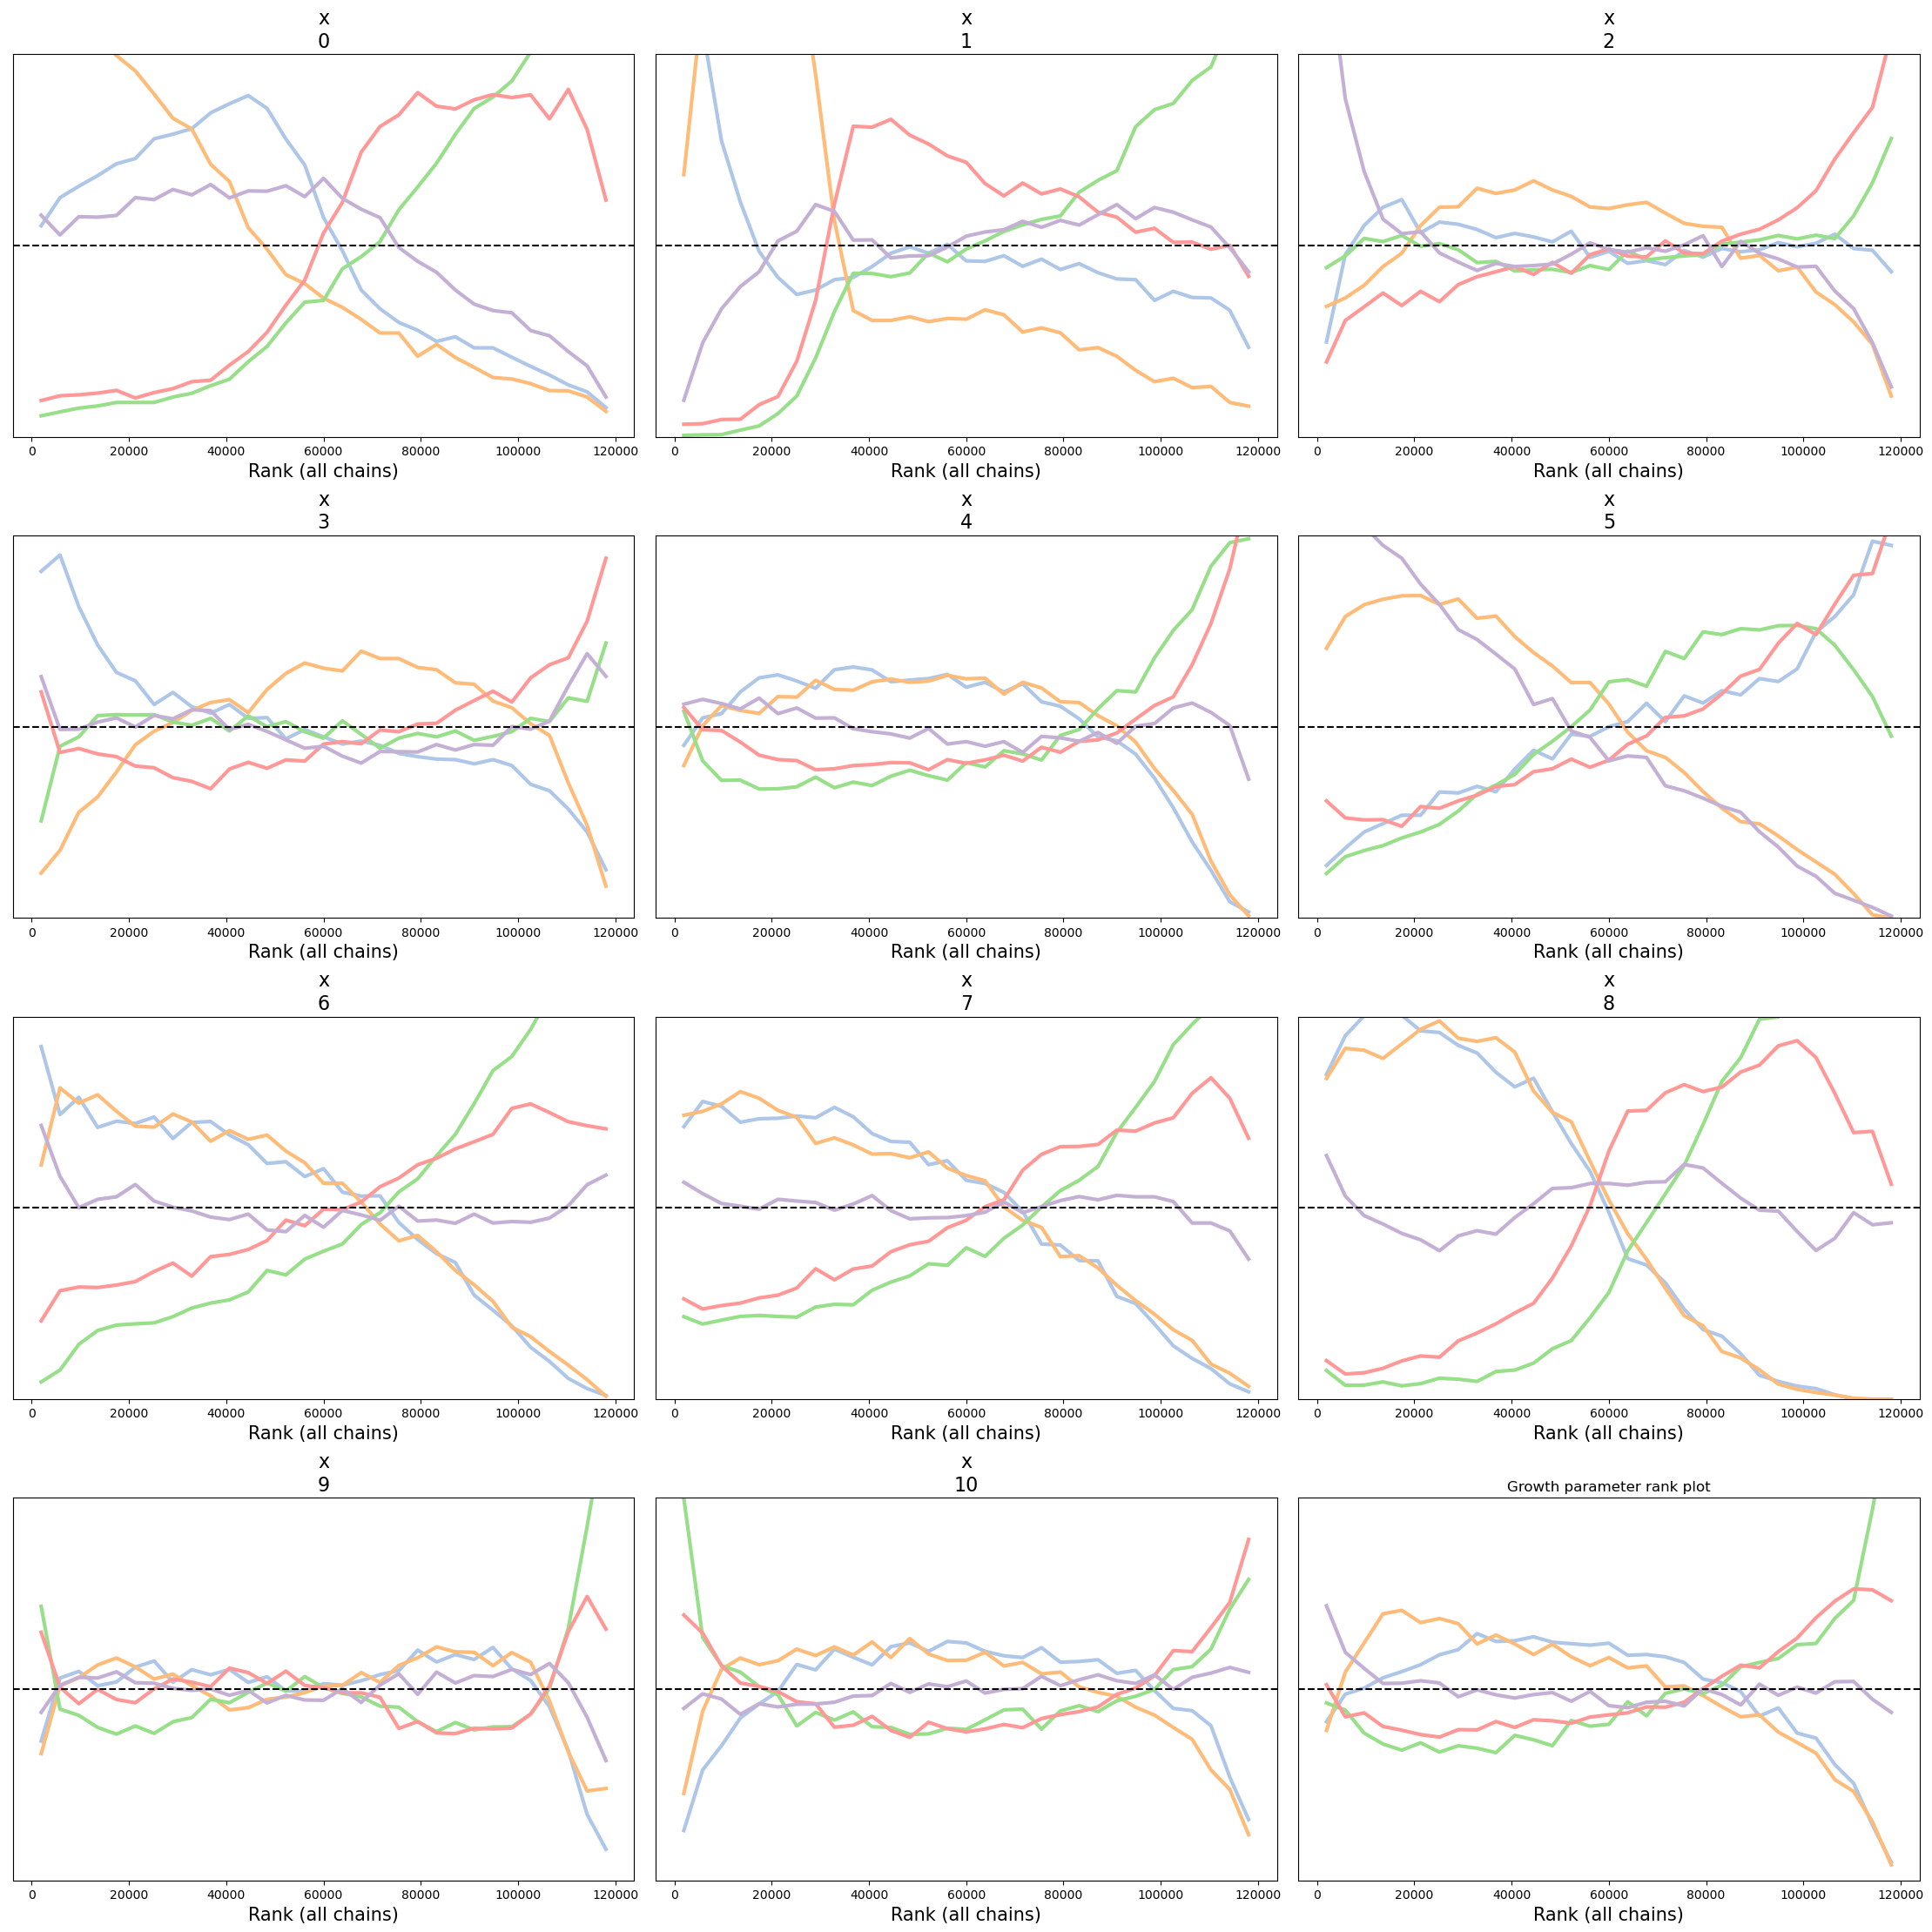

In [114]:
# growth_az = az.convert_to_inference_data(growth)
growth_az = az.convert_to_inference_data(growth)
az.plot_rank(growth_az, kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3}, colors=cols)
plt.title(f'{growth_key} rank plot')

In [94]:
growth_az = az.convert_to_inference_data(growth)
b = az.summary(growth_az)
b.index = taxa
b

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
B_caccae,0.469,0.173,0.193,0.777,0.046,0.033,15.0,123.0,1.26
B_cellulosilyticus_WH2,0.686,0.186,0.334,0.996,0.050,0.036,15.0,34.0,1.26
B_ovatus,1.093,0.149,0.806,1.376,0.020,0.014,55.0,173.0,1.06
B_thetaiotaomicron,0.688,0.132,0.439,0.941,0.013,0.009,100.0,265.0,1.05
B_uniformis,0.378,0.102,0.206,0.581,0.010,0.007,151.0,296.0,1.04
B_vulgatus,0.329,0.118,0.128,0.552,0.026,0.019,20.0,141.0,1.18
C_aerofaciens,0.800,0.183,0.460,1.155,0.039,0.028,23.0,171.0,1.15
C_scindens,0.552,0.149,0.285,0.838,0.029,0.021,28.0,143.0,1.12
C_spiroforme,0.545,0.356,0.063,1.188,0.113,0.082,11.0,114.0,1.37
D_longicatena,0.066,0.065,0.000,0.181,0.002,0.001,1690.0,574.0,1.01


In [103]:
diagn = []
for i in range(len(taxa)):
    species2 = taxa.copy()
    species2.pop(i)
    inter = np.ma.array(interactions[:,:,i,:], mask=False)
    inter.mask[:,:,i] = True
    inter = inter[~inter.mask].reshape(inter.shape[0], inter.shape[1], -1)
    interactions_az = az.convert_to_inference_data(inter)
    interactions_summary = az.summary(interactions_az)
    interactions_summary.index = species2
    interactions_summary.index.name = 'species2'
    interactions_summary['species1'] = taxa[i]
    interactions_summary.reset_index(inplace=True)
    interactions_summary.set_index(['species1', 'species2'], inplace=True)
    diagn.append(interactions_summary)
diagn = pd.concat(diagn)
diagn

mean   sd  hdi_3%  hdi_97%  mcse_mean  \
species1 species2                                                        
B_caccae B_cellulosilyticus_WH2   0.0  0.0     0.0      0.0        0.0   
         B_ovatus                -0.0  0.0    -0.0      0.0        0.0   
         B_thetaiotaomicron      -0.0  0.0     0.0      0.0        0.0   
         B_uniformis              0.0  0.0     0.0      0.0        0.0   
         B_vulgatus              -0.0  0.0     0.0      0.0        0.0   
...                               ...  ...     ...      ...        ...   
R_obeum  C_aerofaciens           -0.0  0.0    -0.0      0.0        0.0   
         C_scindens              -0.0  0.0     0.0      0.0        0.0   
         C_spiroforme            -0.0  0.0     0.0      0.0        0.0   
         D_longicatena            0.0  0.0     0.0      0.0        0.0   
         P_distasonis            -0.0  0.0     0.0      0.0        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
species1 species2                                                    
B_caccae B_cellulosilyticus_WH2      0.0   10581.0    9396.0   1.00  
         B_ovatus                    0.0      23.0     209.0   1.16  
         B_thetaiotaomicron          0.0     711.0  104544.0   1.02  
         B_uniformis                 0.0   18072.0   15341.0   1.00  
         B_vulgatus                  0.0   11340.0   45442.0   1.00  
...                                  ...       ...       ...    ...  
R_obeum  C_aerofaciens               0.0     200.0     266.0   1.04  
         C_scindens                  0.0    9783.0    1430.0   1.02  
         C_spiroforme                0.0    4086.0   34815.0   1.02  
         D_longicatena               0.0   20697.0   16026.0   1.01  
         P_distasonis                0.0     269.0   31885.0   1.03  

[132 rows x 9 columns]